Changes to normflows (see https://github.com/nVentis/normalizing-flows)
- float precision check for discriminant: https://github.com/bayesiains/nflows/pull/71
- init_identity from: https://github.com/VincentStimper/normalizing-flows/blob/848277e2fdd306c16b48dc6814e2d7f8ddaeb2c8/normflows/flows/neural_spline/wrapper.py#L203
- added HypercubeUniform distribution with adjustable boundaries per dimension

In [1]:
import torch
from torchsummary import summary
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from analysis.plot_matplotlib import plot_hist
from analysis.utils import module_reload
import pandas as pd

# NF example

In [2]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
from analysis.nis.distributions import HyperUniform
import normflows as nf
from normflows.distributions import BaseDistribution
from typing import Optional, Callable
import numpy as np
import pandas as pd
import torch

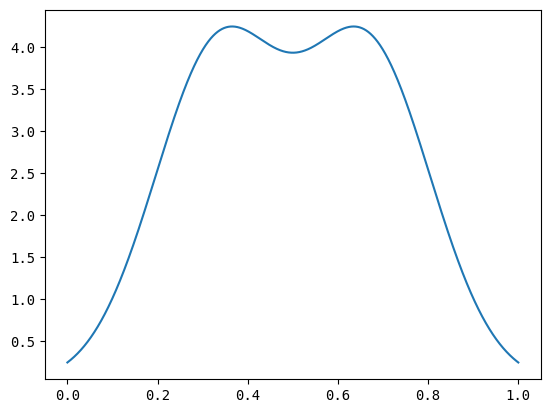

In [3]:
from analysis.mc.benchmarks import camel
n_samples = 10000
x = np.linspace(0, 1, n_samples)
oth = 0.5*np.ones(n_samples)

y = camel(np.array([x, oth, oth, oth]).T)
plt.plot(x, y)

In [7]:
def from_tf(nis:NeuralImportanceSamplingIntegrator, tf_path:str='/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/nis/model_params_tfp.npy'):
    from collections import OrderedDict
    new_state = {}
    
    # PT properties
    from_nis = ['q0.log_prob_val', 'q0.low', 'q0.high']
    for i in range(nis.n_couplings):
        from_nis.append(f'flows.{i}.identity_features')
        from_nis.append(f'flows.{i}.transform_features')
    
    old_state = nis.nfm.state_dict()
    
    for prop in from_nis:
        new_state[prop] = old_state[prop]
    
    # TF properties    
    tf_dict = np.load(tf_path, allow_pickle=True).item()
    for prop in tf_dict:
        new_state[prop] = torch.as_tensor(tf_dict[prop].T)
    
    return OrderedDict(new_state)

def train_backward(nfm, func, n_samples:int=64000, n_epochs:int=10, lr:float=5e-4):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=lr)
    q = nfm.q0.log_prob_val.exp().detach()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        samples, log_p = nfm.sample(n_samples)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(q*prob)) * results**2).sum()
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        else:
            print('Skipping epoch')
            
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()}")

In [5]:
def func(args):
    lib = torch if isinstance(args, torch.Tensor) else np
    return lib.exp(-5*lib.sqrt(args.T[0]**2 + args.T[1]**2 +args.T[2]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)
    
    # old center: new_width/2
    # new center: (max+min)/2

In [10]:
module_reload('analysis')
#torch.cuda.is_available = lambda : False
#torch.set_default_device('cpu')
torch.set_default_dtype(torch.float64)
torch.set_printoptions(sci_mode=True, precision=8)

from analysis.nis.transforms import ScaleShift
from analysis.mc.benchmarks import camel, gaussian
from analysis.nis.analyze import plot_proposal, plot_integrand, get_result
from analysis.nis.divergences import kl_div, chi2_div, exp_div, var_loss
from analysis.mc import NeuralImportanceSamplingIntegrator

ndims = 4
boundaries = [ [0]*ndims, [1]*ndims ]
uniform = HyperUniform(low=boundaries[0], high=boundaries[1], dtype=torch.float64)

nis = NeuralImportanceSamplingIntegrator(integrand=camel, boundaries=boundaries, lr=1e-4, hidden_channels=32,
                                         num_bins=16, hidden_layers=5, shift_scale=False, debug=False, device=torch.device('cpu'))
nis.print_model_summary()

#summary(nis.nfm, (nis.sample(4)[0]), depth=5)
#plot_proposal(nis.nfm, n_samples=10000)

if False:
    for name, param in nis.nfm.named_parameters():
        if param.requires_grad:
            print(name, param.data.dtype, param.data)

a = nis.q0.sample(2)
#print(a)
#print(nis.q0.log_prob(a))

logp = nis.nfm.log_prob(a)
print('log_prob', logp.dtype, logp)

# Use weights from TF model
if False:
    new_state = from_tf(nis)
    nis.nfm.load_state_dict(new_state)

Using device cpu
Model with 25992 parameters
log_prob torch.float64 tensor([4.44089210e-16, 0.00000000e+00], grad_fn=<AddBackward0>)


Using inferred bounds 9.099348149410602e-07 to 0.9999997719971934


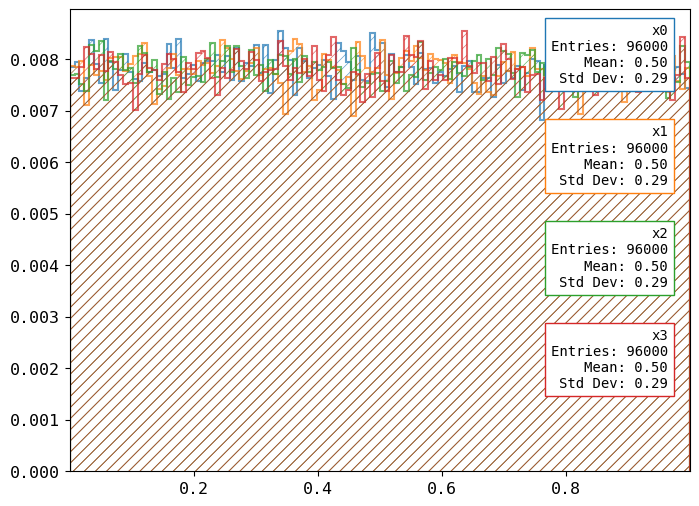

In [11]:
plot_proposal(nis.nfm, n_samples=96000)

In [12]:
#plot_proposal(nis.nfm, n_samples=8192)
#plot_proposal(nis.q0, n_samples=8192)

print(f'NF @ Identity : {get_result(nis.nfm, camel, n_samples=32000)}')
print(f'Uniform dist  : {get_result(uniform, camel, n_samples=32000)}')

# samples, log_p = nfm.sample(1000)
# results = func(samples).detach().cpu().numpy()

# plot_integrand(nfm, func, n_samples=4096)

NF @ Identity : (0.9749000318584844, 6.991595163346064)
Uniform dist  : (0.9735825633287364, 7.062938070985033)


  0%|          | 0/300 [00:00<?, ?it/s]

true 5000.000
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
26.44974492454924 399.61452462551324
Using inferred bounds 7.166833171030677e-06 to 0.9999979996694544
true 5009.422
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
28.755040744115703 370.412791916342
true 5017.326
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
28.285651656746737 432.79225364728967
true 5024.190
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
30.809390381918302 392.47485879242254
true 5035.318
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
29.10025750450234 443.4867716568768
true 5043.717
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
29.22984408242748 422.77835108641204
true 5054.828
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
32.906863868214046 411.91420328733625
true 5060.694
torch.Size([5000]) torch.Size(

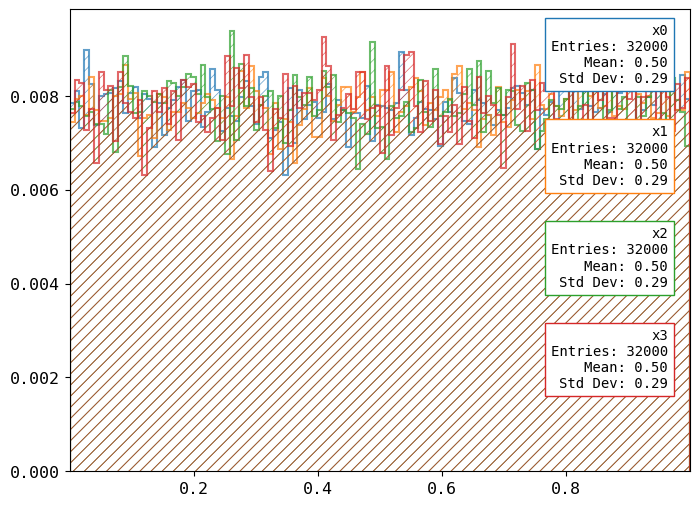

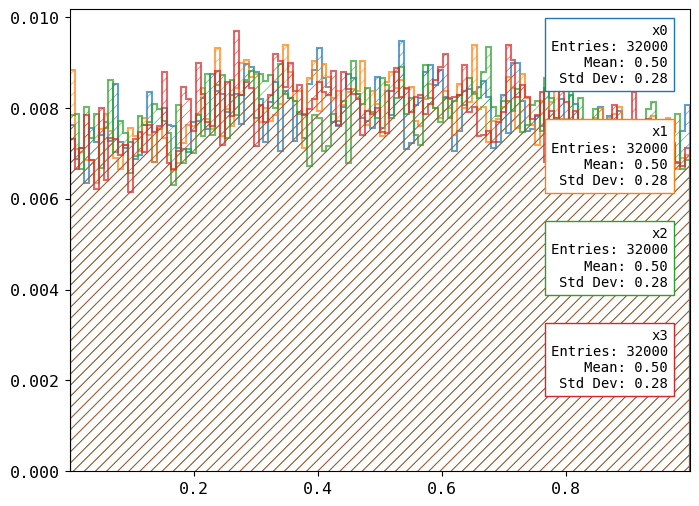

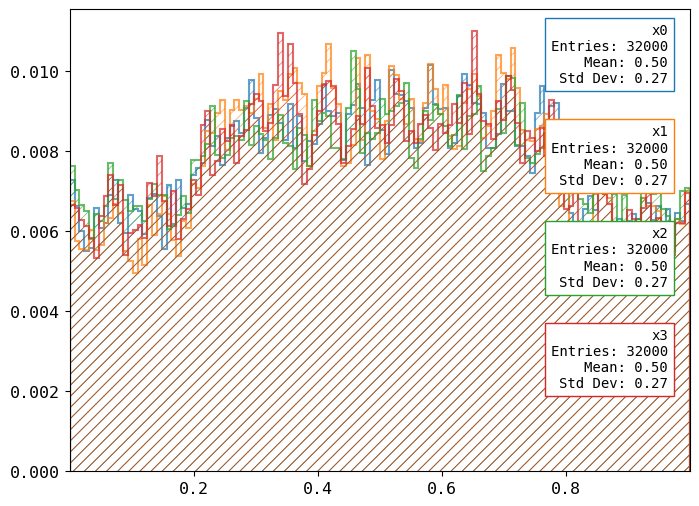

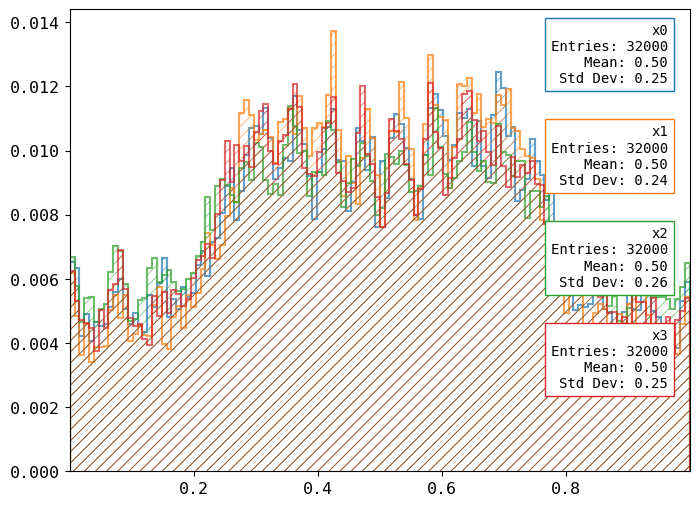

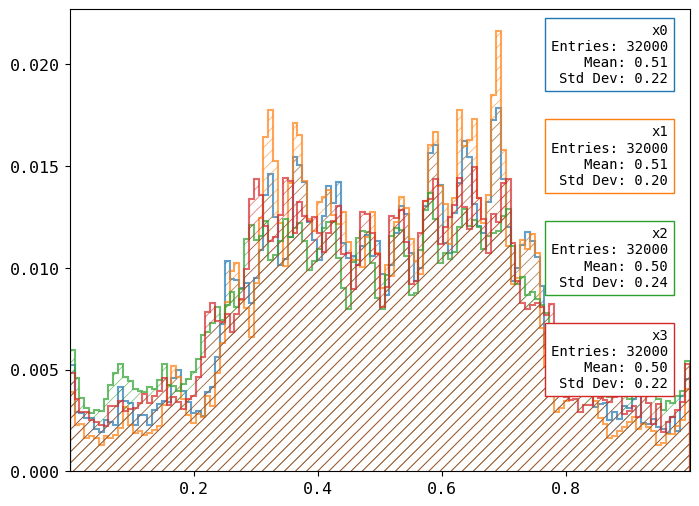

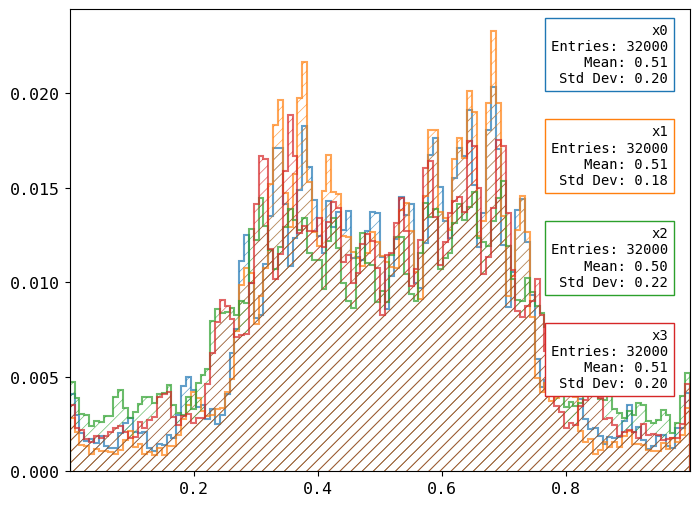

In [13]:
def report(nis):
    if nis.epoch_abs % 50 == 0:
        with torch.no_grad():
            plot_proposal(nis.nfm, n_samples=32000)

nis.adapt(n_epochs_max=300, loss_func=exp_div, n_samples=5000, n_max_fail=50, test_callback=report)
nis.empty_cache()

#plot_proposal(nis.nfm, n_samples=32000)

In [63]:
# nis.save('/root/DevRepositories/MEM_HEP/camel4.pt')

Estimate: None


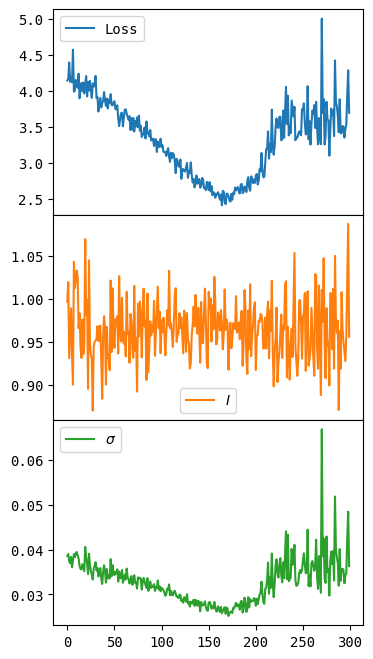

In [14]:
from analysis.plot_matplotlib import get_colorpalette

losses = nis.statistics['train_losses']
means = nis.statistics['train_results']
stddevs = nis.statistics['train_sigmas']

palette = get_colorpalette()
fig, ax = plt.subplots(3, 1, figsize=(4,8), gridspec_kw={'hspace': 0, 'wspace': 0})
ax[0].plot(np.arange(len(losses)), losses, label=r'Loss', color=palette[0])
ax[0].set_xlabel(r'Epoch')

ax[1].plot(np.arange(len(means)), means, label=r'$I$', color=palette[1])
ax[2].plot(np.arange(len(stddevs)), stddevs, label=r'$\sigma$', color=palette[2])

for i in range(len(ax)):
    ax[i].legend(loc='best')
    
print(f'Estimate: {nis.evaluate()}')

In [246]:
from tqdm.auto import tqdm

n_runs = 300
means = np.zeros(n_runs, dtype=float)
sigmas = np.zeros(n_runs, dtype=float)
for i in tqdm(range(n_runs)):
    mean, sigma = nis.evaluate(n_samples=5000, revert=False, use_best=False)
    means[i] = mean
    sigmas[i] = sigma

  0%|          | 0/300 [00:00<?, ?it/s]

indices tensor([2, 0, 3, 1])
indices tensor([0, 2, 1, 3])
indices tensor([2, 3, 0, 1])
indices tensor([0, 1, 2, 3])
true 15600.593
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
indices tensor([2, 0, 3, 1])
indices tensor([0, 2, 1, 3])
indices tensor([2, 3, 0, 1])
indices tensor([0, 1, 2, 3])
true 15819.103
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
indices tensor([2, 0, 3, 1])
indices tensor([0, 2, 1, 3])
indices tensor([2, 3, 0, 1])
indices tensor([0, 1, 2, 3])
true 15189.578
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
indices tensor([2, 0, 3, 1])
indices tensor([0, 2, 1, 3])
indices tensor([2, 3, 0, 1])
indices tensor([0, 1, 2, 3])
true 15410.568
torch.Size([5000]) torch.Size([5000]) torch.Size([5000]) torch.Size([5000])
indices tensor([2, 0, 3, 1])
indices tensor([0, 2, 1, 3])
indices tensor([2, 3, 0, 1])
indices tensor([0, 1, 2, 3])
true 15534.023
torch.Size([5000]) torch.Size([5000]) tor

In [250]:
print(np.mean(means))

0.9644429529512965


(array([ 2., 15., 36., 63., 53., 68., 40., 18.,  2.,  3.]),
 array([0.90958276, 0.9214264 , 0.93327004, 0.94511367, 0.95695731,
        0.96880094, 0.98064458, 0.99248821, 1.00433185, 1.01617548,
        1.02801912]),
 <BarContainer object of 10 artists>)

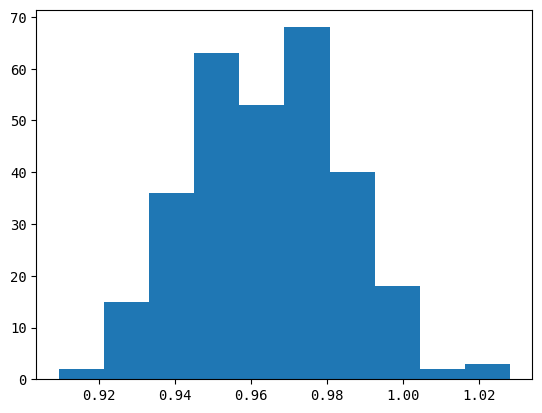

In [247]:
plt.hist(means)

(array([ 8., 25., 57., 62., 67., 43., 20., 14.,  2.,  2.]),
 array([0.01895429, 0.0192291 , 0.01950392, 0.01977873, 0.02005354,
        0.02032836, 0.02060317, 0.02087798, 0.0211528 , 0.02142761,
        0.02170242]),
 <BarContainer object of 10 artists>)

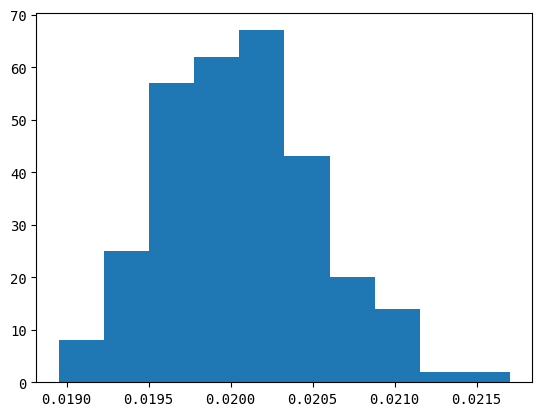

In [248]:
plt.hist(sigmas)